In [319]:
import pandas as pd
import numpy as np
import random
import pickle
import copy
import matplotlib.pyplot as plt

In [275]:
def turn_ones(x):
    if x is True:
        return 1
    else:
        return 0
    
class Queries:
    def __init__(self, num_race, num_hisp, num_age, num_sex, 
                 race_col, hisp_col, age_col, sex_col):
        self.total = 0
        
        # save_params
        self.num_race = num_race
        self.num_hisp = num_hisp
        self.num_age = num_age
        self.num_sex = num_sex

        self.race_col = race_col
        self.hisp_col = hisp_col
        self.age_col = age_col
        self.sex_col = sex_col
        
        # initialize arrays
        self.races = np.zeros(num_race) 
        self.race_hisp = np.zeros([num_race, num_hisp])
        self.nh_race_age = np.zeros([num_race, num_age])
        self.age_sex = np.zeros([num_age, num_sex])
        
    def add_total(self, block):
        self.total = len(block)

    def add_races(self, block):
        for (k, v) in block[self.race_col].value_counts().items():
            self.races[k] = v
    
    def add_race_hisp(self, block):
        for race in range(self.num_race):
            for hisp in range(self.num_hisp):
                self.race_hisp[race, hisp] = len(block.query(f'{self.hisp_col} == {hisp} and {self.race_col} == {race}'))
                
    def add_nh_race_age(self, block):
        for race in range(self.num_race):
            for age in range(self.num_age):
                self.nh_race_age[race, age] = len(block.query(f'{self.hisp_col} == 0 and {self.race_col} == {race} and {self.age_col} == {age}'))
                
    def add_age_sex(self, block):
        for age in range(self.num_age):
            for sex in range(self.num_sex):
                self.age_sex[age, sex] = len(block.query(f'{self.sex_col} == {sex} and {self.age_col} == {age}'))
                
    def generate_queries(self, block):
        """
        """
        self.add_total(block)
        self.add_races(block)
        self.add_race_hisp(block)
        self.add_nh_race_age(block)
        self.add_age_sex(block)
                
    def print_state(self):
        print("Total: ", self.total)
        print("Races: ", self.races)
        print("Race_Hisp: ", self.race_hisp)
        print("NH_Race_Age: ", self.nh_race_age)
        print("Age_Sex: ", self.age_sex)

def query_manager(block):
    """
    """
    num_race = 7
    num_hisp = 2
    num_sex = 2
    num_age = 2
    
    race_col = "CENRACE"
    hisp_col = "CENHISP"
    age_col = "QAGE"
    sex_col = "QSEX"
    
    queries = Queries(num_race, num_hisp, num_sex, num_age, race_col, hisp_col, age_col, sex_col)
    queries.generate_queries(block)

    return queries

def construct_row(q, verbose=False):
    """
    """
    if verbose:
        print("Printing state:")
        q.print_state()
    
    race_prob = q.races/ q.total
    rrace = np.random.choice(range(q.num_race), p=race_prob)
    
    hisp_prob = q.race_hisp[rrace]/ q.race_hisp[rrace].sum()
    rhisp = np.random.choice(range(q.num_hisp), p=hisp_prob)
    
    if rhisp == 0: 
        age_prob = q.nh_race_age[rrace] / q.nh_race_age[rrace].sum()
    else:             
        age_prob = q.age_sex.sum(axis=1) / q.total
    
    rage = np.random.choice(range(q.num_age), p=age_prob)
    
    sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()
    rsex = np.random.choice(range(q.num_sex), p=sex_prob)
    
    return (rrace, rhisp, rage, rsex)


def add_row_to_reconstruction(recon_df, row, blk_id):
    """
    """
    rrace, rhisp, rage, rsex = row
    recon_df.loc[len(recon_df)] = [blk_id, rrace, rhisp, rage, rsex]
    
def reconstruct_block(blk_id, queries, verbose=False):
    """
    """
    q = copy.deepcopy(queries)
    
    if q.total == 0:
        print("Skipping Block ", blk_id, "because Queries are empty.")
        return
    
    recon_df = pd.DataFrame(columns=["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"])
    for _ in range(q.total):
        row = construct_row(q, verbose=verbose)
        add_row_to_reconstruction(recon_df, row, blk_id)
        remove_row_from_queries(row, q)
        
    return recon_df

def remove_row_from_queries(row, q):
    rrace, rhisp, rage, rsex = row
    
    q.total -= 1
    q.races[rrace] -= 1
    q.race_hisp[rrace, rhisp] -= 1
    
    if rhisp == 0:
        q.nh_race_age[rrace, rage] -= 1
        
    q.age_sex[rage, rsex] -= 1
    
def reconstruct_tract(queries):
    """
    """
    main_df = pd.DataFrame(columns=["TABBLK", "CENRACE", "CENHISP", "QAGE", "QSEX"])

    for (block_id, block_queries) in queries.items():
        recon_df = reconstruct_block(block_id, block_queries)
        main_df = pd.concat([main_df, recon_df])
        
    return main_df

def tests_passed(real_queries, recon_df):
    """
    """
    reconq = get_block_queries(recon_df)
    
    for (block_id, realq) in real_queries.items():
        assert(realq.total == reconq[block_id].total)
        assert(np.sum(realq.races == reconq[block_id].races) == realq.num_race)
        assert(np.sum(realq.race_hisp == reconq[block_id].race_hisp) == (realq.num_race * realq.num_hisp))
        assert(np.sum(realq.nh_race_age == reconq[block_id].nh_race_age) == (realq.num_race * realq.num_age))
        assert(np.sum(realq.age_sex == reconq[block_id].age_sex) == (realq.num_age * realq.num_sex))
        
    return True
    
def get_block_queries(df):
    """
    """
    block_queries = {}
    
    for block_id in sorted(df["TABBLK"].unique()):
        block = df[df["TABBLK"] == block_id]
        block_queries[block_id] = query_manager(block)
    
    return block_queries
        
def get_num_reconstructed(recon, real):
    """
        `recon' and `real' are both pandas DataFrames.
    """
    real_unique = real.groupby(real.columns.tolist(), as_index=False).size()
    recon_unique = recon.groupby(recon.columns.tolist(), as_index=False).size()
    
    num_reconstructed = 0
    
    for idx, recon_row in recon_unique.iterrows():
        (blk, race, hisp, age, sex, size) = recon_row
        real_row = real_unique.query(f'TABBLK == {blk} and ' +
                                     f'CENRACE == {race} and ' +
                                     f'CENHISP == {hisp} and ' +
                                     f'QAGE == {age} and ' +
                                     f'QSEX == {sex}')

        if len(real_row) > 0:
            num_reconstructed += min(real_row["size"].item(), size)
    
    return num_reconstructed

In [276]:
df = pd.read_csv("./dp-query-release/datasets/ppmf/ppmf_01097007000.csv")
df = df[['TABBLK', 'CENRACE', 'CENHISP', 'QAGE', 'QSEX']]
df["QAGE"] = df["QAGE"].apply(lambda x: x >= 18).apply(turn_ones) 
df["CENRACE"] = df["CENRACE"].apply(lambda x: x if x <= 5 else 6)

all_block_queries = get_block_queries(df)
recon = reconstruct_tract(all_block_queries)
recon

,TABBLK,CENRACE,CENHISP,QAGE,QSEX
0,0,0,1,1,1
1,0,0,1,1,1
2,0,0,1,1,1
3,0,0,1,1,1
4,0,0,1,1,1
...,...,...,...,...,...
56,113,0,1,1,0
57,113,0,1,1,1
58,113,0,1,1,1
59,113,0,1,1,0


In [235]:
# we can simply concatenate all of our reconstructions. 
# furthermore, we can also get a confidence score on our rows. why not? especially the fully determined ones. 

In [277]:
tests_passed(all_block_queries, recon)

True

In [278]:
get_num_reconstructed(recon, df)

4173

In [294]:
all_recons = pd.DataFrame(columns=df.columns)
counter = 0
while counter <100:
    try:
        recon = reconstruct_tract(all_block_queries)
        print(counter)
        counter += 1
        all_recons = pd.concat([all_recons, recon])
    except:
        continue

0
1
2
3
4


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


5
6


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()
/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


7
8
9
10
11
12
13
14
15
16
17
18
19
20


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


21


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


22
23
24
25
26
27
28
29
30
31
32


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


33
34
35


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


36
37
38
39
40


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


41
42
43
44


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


45
46
47
48


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


49
50
51


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


52
53


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


54
55
56
57


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()
/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


75
76
77
78
79
80
81


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


82
83
84
85
86
87


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


88


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


89
90
91
92
93


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


94
95


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_85846/1204387978.py:105: RuntimeWarning: invalid value encountered in divide
  sex_prob = q.age_sex[rage] / q.age_sex[rage].sum()


96
97
98
99


In [295]:
all_recons_unique = all_recons.groupby(all_recons.columns.tolist(), as_index=False).size()
all_recons_unique

,TABBLK,CENRACE,CENHISP,QAGE,QSEX,size
0,0,0,1,1,1,500
1,1,0,1,0,0,600
2,1,0,1,1,0,8000
3,1,0,1,1,1,4700
4,2,0,1,1,0,187
...,...,...,...,...,...,...
567,113,1,1,1,1,55
568,113,6,1,0,0,33
569,113,6,1,0,1,60
570,113,6,1,1,0,81


In [298]:
all_recons_unique = all_recons_unique.sort_values(by=['size'], ascending=False)
all_recons_unique

,TABBLK,CENRACE,CENHISP,QAGE,QSEX,size
209,53,0,1,1,1,11167
387,83,0,1,1,0,10020
128,32,0,1,1,1,8300
2,1,0,1,1,0,8000
19,7,0,1,1,1,7800
...,...,...,...,...,...,...
119,29,2,1,1,0,5
66,17,5,1,0,0,5
431,89,3,1,0,1,4
501,98,2,1,0,0,2


In [314]:
def match_rate(recon, real, k):
    """
    """
    num_reconstructed = 0
    for i in range(k):
        (blk, race, hisp, age, sex, size) = recon.iloc[i]
        real_row = real.query(f'TABBLK == {blk} and ' +
                              f'CENRACE == {race} and ' +
                              f'CENHISP == {hisp} and ' +
                              f'QAGE == {age} and ' +
                              f'QSEX == {sex}')

        if len(real_row) > 0:
            num_reconstructed += 1
    
    return num_reconstructed / k

In [315]:
match_rate(all_recons_unique, df, 570)

0.6771929824561403

In [318]:
u = len(all_recons_unique)

xs = []
ys = []

for k in range(1, u):
    mr = match_rate(all_recons_unique, df, k)
    
    xs.append(k/u)
    ys.append(mr)

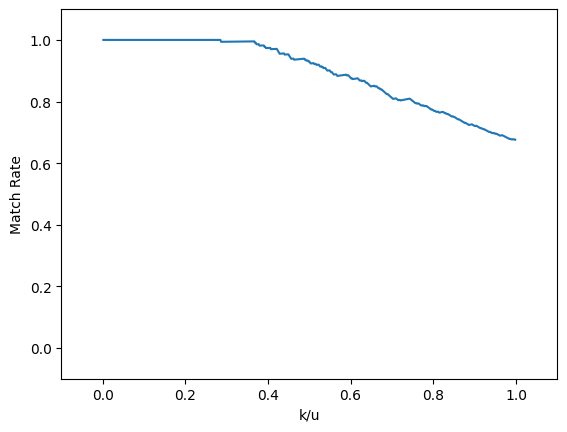

In [325]:
plt.plot(xs, ys)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("Match Rate")
plt.xlabel("k/u")
plt.savefig("coarse_matchrate.png")